In [1]:
# Multi-Layer Perception Classification of MNIST Dataset

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision

from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
batch_size = 256
data_set_root = "../datasets"

# Create a train and test dataset using the Pytorch MNIST dataloader class
train = MNIST(data_set_root, train=True,  download=True, transform=transforms.ToTensor())
test  = MNIST(data_set_root, train=False, download=True, transform=transforms.ToTensor())

# Using the Pytorch dataloader class and the Pytorch datasets we with create itterable dataloader objects
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False) 
test_loader = dataloader.DataLoader(test, shuffle=False, batch_size=batch_size, num_workers=0, pin_memory=False)

# NOTE:num_workers is the number of extra threads the dataloader will spawn to load the data from file, 
# you will rarely need more than 4 
# NOTE!!! ON WINDOWS THERE CAN BE ISSUES WITH HAVING MORE THAN 0 WORKERS!! IF YOUR TRAINING LOOP STALLS AND DOES
# NOTHING SET num_workers TO 0!

# NOTE:pin_memory is only useful if you are training with a GPU!!!! If it is True then the GPU will pre-allocate
# memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

In [4]:
# Set device to GPU_indx if GPU is avaliable
# GPU index is set by the NVIDIA Drivers if you have only one GPU then it should always be 0
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

In [5]:
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape)
print("The target output data shape is :\n", labels.shape)

The input data shape is :
 torch.Size([256, 1, 28, 28])
The target output data shape is :
 torch.Size([256])


In [6]:
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape)
print("The target output data shape is :\n", labels.shape)

The input data shape is :
 torch.Size([256, 1, 28, 28])
The target output data shape is :
 torch.Size([256])


In [7]:
# Lets create a simple MLP network similar to the sine wave approximator
class Simple_MLP(nn.Module):
    def __init__(self, num_classes):
        super(Simple_MLP, self).__init__()
        # We will use 4 linear layers
        # The input to the model is 784 (28x28 - the image size)
        # and the should be num_classes outputs
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        # The data we pass the model is a batch of single channel images
        # with shape BSx1x28x28 we need to flatten it to BSx784
        # To use it in a linear layer
        x = x.reshape(x.shape[0], -1)
        
        # We will use a relu activation function for this network! (F.relu)
        # NOTE F.relu is the "functional" version of the activation function!
        # nn.ReLU is a class constructor of a "ReLU" object
        # These two things are the same for MOST purposes!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
# Create our model
model = Simple_MLP(10).to(device)
# Create our loss function
criterion = nn.CrossEntropyLoss()
# Define our loss funcition and optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

# Number of Epochs
n_epochs = 16

# We can print out our model structure
print(model)
# Note: this is only the order in which the layers were defined NOT the path of the forward pass!

Simple_MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
def train_epoch(model, train_loader, criterion, optimizer, loss_logger):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training", leave=False)):   
        outputs = model(data.to(device))
        loss = criterion(outputs, target.to(device))
        
        optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        
        loss_logger.append(loss.item())

    return model, optimizer, loss_logger

In [10]:

def test_model(model, test_loader, criterion, loss_logger):
    
    # With no_grad we don't need pytorch to track our operations here
    # We can speed up our evaluation by turning auto grad off
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):   
            outputs = model(data.to(device))
            
            # Calculate the accuracy of the model
            # you'll need to accumulate the accuracy over multiple steps
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == target.to(device)).sum().item()
            total_predictions += target.shape[0]
            
            # Calculate the loss
            loss = criterion(outputs, target.to(device))
            loss_logger.append(loss.item())
            
        acc = (correct_predictions/total_predictions) * 100.0
        return loss_logger, acc

In [11]:

train_loss = []
test_loss  = []
test_acc   = []

In [12]:
for i in trange(n_epochs, desc="Epoch", leave=False):
    model, optimizer, train_loss = train_epoch(model, train_loader, criterion, optimizer, train_loss)
    test_loss, acc = test_model(model, test_loader, criterion, test_loss)
    test_acc.append(acc)
    
print("Final Accuracy: %.2f%%" % acc)

Epoch:   0%|          | 0/16 [00:00<?, ?it/s]

Final Accuracy: 98.17%


In [13]:
x = model(images.to(device))


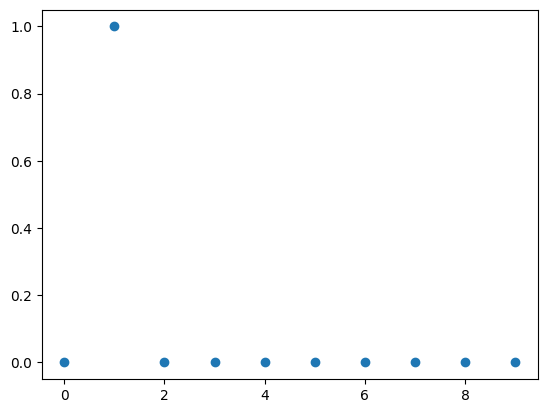

In [14]:
plt.scatter(np.arange(10), F.softmax(x, 1)[0].detach().cpu().numpy())


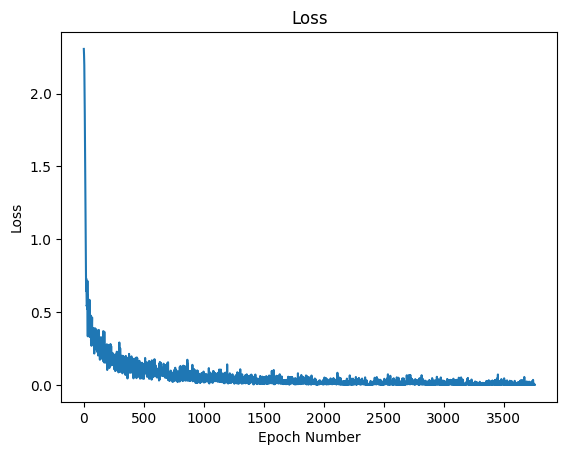

In [15]:

plt.title('Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)

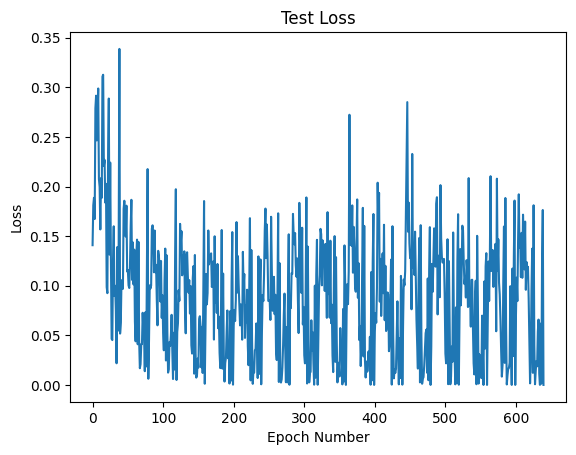

In [16]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(test_loss)


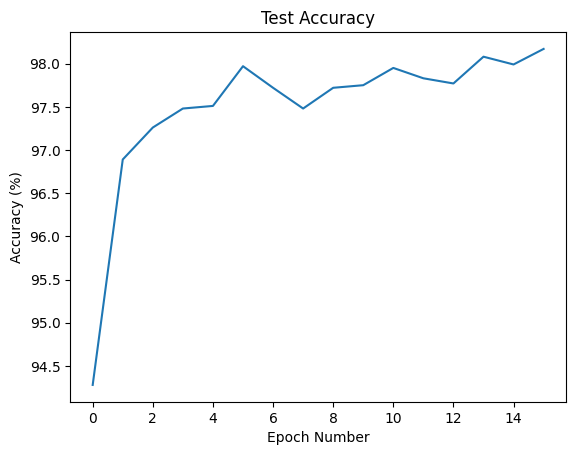

In [17]:

plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(test_acc)